### Import Libraries and Load Data

In [103]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.vector_ar.var_model import VAR

# Load dataset
file_path = "US_Japan.xlsx"
df = pd.read_excel(file_path)

# Display the first few rows to understand the dataset structure
df.head()

,Year,Nominal Exchange Rate (USD/JPY),Real Exchange Rate (USD/JPY),CPI (US),CPI (Japan)
0,1995,94.059579,68.549696,69.882820,95.888808
1,1996,108.779057,81.489565,71.931229,96.019793
2,1997,120.990863,91.163260,73.612758,97.698031
3,1998,130.905301,99.505879,74.755433,98.344767
4,1999,113.906805,88.782212,76.391102,98.009119


### Data Preprocessing and Log Transformation

In [104]:
# Rename columns for consistency
df.rename(columns={
    'Nominal Exchange Rate (USD/JPY)': 'nominal_exchange_rate',
    'Real Exchange Rate (USD/JPY)': 'real_exchange_rate',
    'CPI (US)': 'CPI_home',
    'CPI (Japan)': 'CPI_foreign'
}, inplace=True)

# Log transformations of exchange rates and CPIs to stabilize variance
df['log_nominal_exchange_rate'] = np.log(df['nominal_exchange_rate'])
df['log_real_exchange_rate'] = np.log(df['real_exchange_rate'])
df['log_CPI_home'] = np.log(df['CPI_home'])
df['log_CPI_foreign'] = np.log(df['CPI_foreign'])

# Display the transformed data
df[['log_nominal_exchange_rate', 'log_real_exchange_rate', 'log_CPI_home', 'log_CPI_foreign']].head()

,log_nominal_exchange_rate,log_real_exchange_rate,log_CPI_home,log_CPI_foreign
0,4.543928,4.227559,4.246820,4.563189
1,4.689319,4.400475,4.275711,4.564554
2,4.795715,4.512652,4.298818,4.581881
3,4.874474,4.600217,4.314222,4.588479
4,4.735381,4.486186,4.335866,4.585061


### Plotting Nominal and Real Exchange Rates

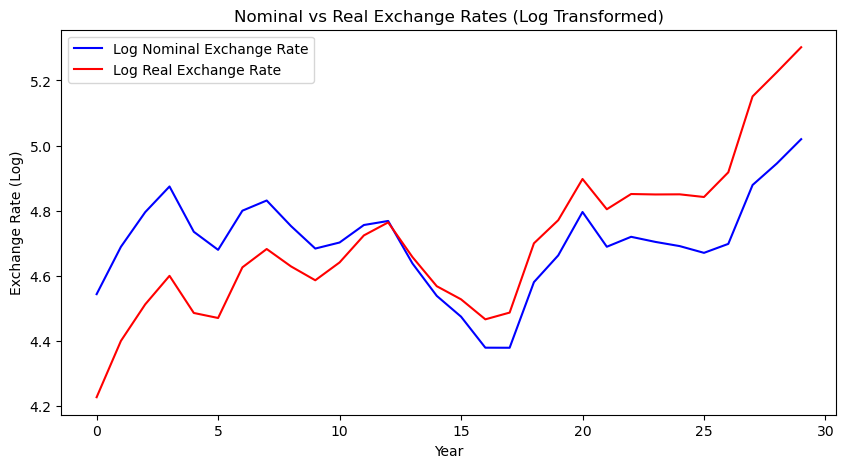

In [105]:
# Plotting Nominal and Real Exchange Rates (Log Transformed)
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['log_nominal_exchange_rate'], label="Log Nominal Exchange Rate", color='blue')
plt.plot(df.index, df['log_real_exchange_rate'], label="Log Real Exchange Rate", color='red')
plt.legend()
plt.title("Nominal vs Real Exchange Rates (Log Transformed)")
plt.xlabel("Year")
plt.ylabel("Exchange Rate (Log)")
plt.show()

### Plotting CPI Trends for Both Countries

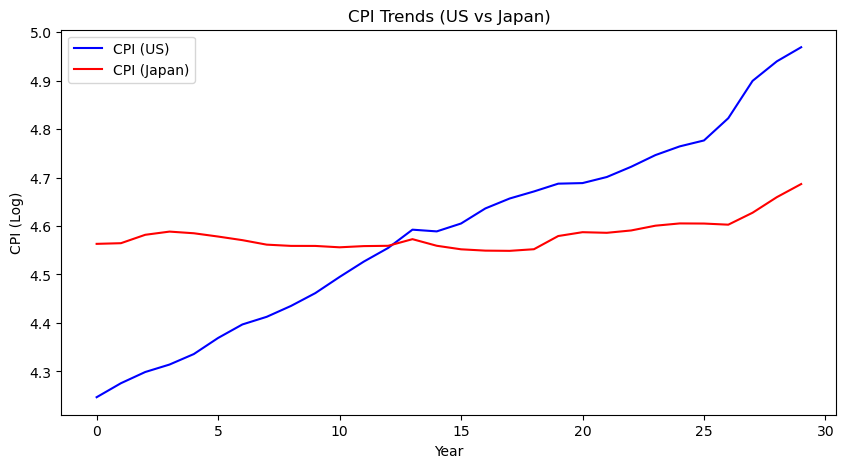

In [106]:
# Plotting CPI trends for both the US and Japan (Log Transformed)
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['log_CPI_home'], label="CPI (US)", color='blue')
plt.plot(df.index, df['log_CPI_foreign'], label="CPI (Japan)", color='red')
plt.legend()
plt.title("CPI Trends (US vs Japan)")
plt.xlabel("Year")
plt.ylabel("CPI (Log)")
plt.show()

### ADF Test for Stationarity

In [107]:
# Augmented Dickey-Fuller (ADF) test for stationarity
def adf_test(series, label):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"\nADF Test for {label}:")
    print(f"Test Statistic: {result[0]}")
    print(f"P-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    print(f"Conclusion: {'Stationary' if result[1] < 0.05 else 'Non-Stationary'}\n")

# Perform ADF test on the log-transformed real exchange rate
adf_test(df['log_real_exchange_rate'], "Log Real Exchange Rate")


ADF Test for Log Real Exchange Rate:
Test Statistic: -0.5291858176726869
P-value: 0.8861941504759547
Critical Values: {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}
Conclusion: Non-Stationary



### Differencing the Data (if required)

In [108]:
# Differencing to make the data stationary if necessary
df['diff_log_real_exchange_rate'] = df['log_real_exchange_rate'].diff()

# Check the first few rows of the differenced data
df['diff_log_real_exchange_rate'].head()

0         NaN
1    0.172916
2    0.112177
3    0.087565
4   -0.114030
Name: diff_log_real_exchange_rate, dtype: float64

### PPP Calculation

In [110]:
# Calculate absolute PPP
df['absolute_ppp'] = df['log_nominal_exchange_rate'] - (df['log_CPI_home'] - df['log_CPI_foreign'])

# OLS Regression for Absolute PPP
abs_ppp_test = sm.OLS(df['absolute_ppp'], sm.add_constant(np.ones(len(df)))).fit()
print(abs_ppp_test.summary())

                            OLS Regression Results                            
Dep. Variable:           absolute_ppp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 10 Apr 2025   Prob (F-statistic):                nan
Time:                        20:13:48   Log-Likelihood:                 2.3861
No. Observations:                  30   AIC:                            -2.772
Df Residuals:                      29   BIC:                            -1.371
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6981      0.041    113.214      0.0

### Relative PPP Calculation

In [111]:
# Calculate relative PPP (inflation differentials and exchange rate changes)
df['inflation_diff'] = df['log_CPI_home'].diff() - df['log_CPI_foreign'].diff()
df['exchange_rate_change'] = df['log_nominal_exchange_rate'].diff()

# Perform regression for Relative PPP
relative_ppp_test = sm.OLS(df['exchange_rate_change'].dropna(), sm.add_constant(df['inflation_diff'].dropna())).fit()
print(relative_ppp_test.summary())

                             OLS Regression Results                             
Dep. Variable:     exchange_rate_change   R-squared:                       0.016
Model:                              OLS   Adj. R-squared:                 -0.020
Method:                   Least Squares   F-statistic:                    0.4527
Date:                  Thu, 10 Apr 2025   Prob (F-statistic):              0.507
Time:                          20:13:53   Log-Likelihood:                 28.333
No. Observations:                    29   AIC:                            -52.67
Df Residuals:                        27   BIC:                            -49.93
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.033

### ACF and PACF for Model Order Selection

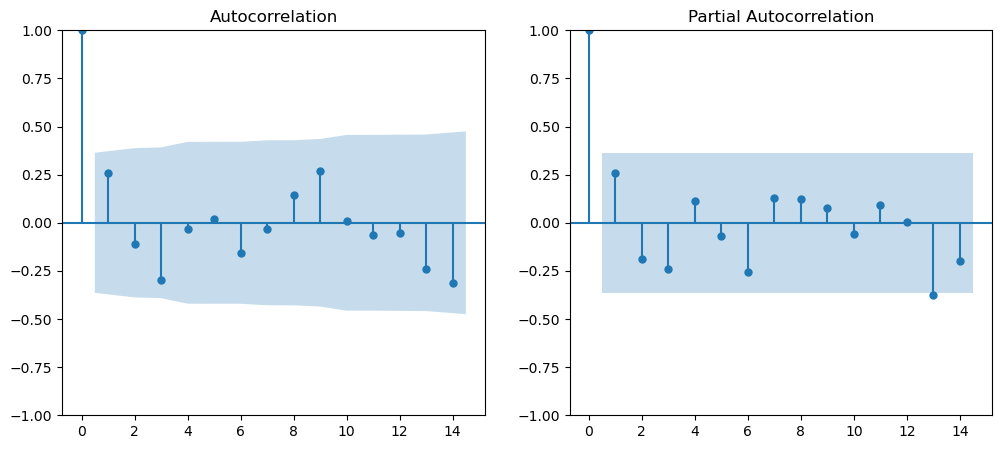

In [112]:
# ACF and PACF plots to help with model order selection (for ARIMA)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(df['diff_log_real_exchange_rate'].dropna(), ax=axes[0])
sm.graphics.tsa.plot_pacf(df['diff_log_real_exchange_rate'].dropna(), ax=axes[1])
plt.show()

### Fit Multiple ARIMA Models and Check Coefficients

In [96]:
pip install --upgrade statsmodels

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/jupyter-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/jsonpointer-3.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [113]:
# Model definitions
models = {
    'AR(1)': ARIMA(df['log_real_exchange_rate'], order=(1, 0, 0)),
    'MA(1)': ARIMA(df['log_real_exchange_rate'], order=(0, 0, 1)),
    'ARMA(1,1)': ARIMA(df['log_real_exchange_rate'], order=(1, 0, 1)),
    'ARIMA(1,1,1)': ARIMA(df['log_real_exchange_rate'], order=(1, 1, 1)),
    'SARIMA(1,1,1)(1,1,1,12)': SARIMAX(df['log_real_exchange_rate'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)),
    'VAR Model': 'var'
}

alpha = 0.05
results = []

# Fit models and collect results
for model_name, model in models.items():
    row = {'Model': model_name}
    
    if model_name != 'VAR Model':
        # Fit model with warnings suppressed
        with pd.option_context('mode.chained_assignment', None):
            fitted_model = model.fit()
        
        row.update({
            'AIC': round(fitted_model.aic, 2),
            'P-Values': f"Coefficients: {[round(p, 4) for p in fitted_model.pvalues]}",
        })
        
        # Ljung-Box test
        lb_pvalue = acorr_ljungbox(fitted_model.resid, lags=[10], return_df=True)['lb_pvalue'][10]
        row.update({
            'Ljung-Box P-Value': round(lb_pvalue, 2),
            'Autocorrelation': "No" if lb_pvalue > alpha else "Yes"
        })
    else:
        # VAR Model handling
        var_data = df[['log_real_exchange_rate', 'log_CPI_home', 'log_CPI_foreign']].dropna()
        var_results = VAR(var_data).fit(maxlags=5, ic='aic')
        
        # Calculate average Ljung-Box p-value across all variables
        lb_pvalues = [
            acorr_ljungbox(var_results.resid[col], lags=[10], return_df=True)['lb_pvalue'][10] 
            for col in var_results.resid.columns
        ]
        row.update({
            'AIC': round(var_results.aic, 2),
            'P-Values': "N/A (Multivariate)",
            'Ljung-Box P-Value': round(sum(lb_pvalues) / len(lb_pvalues), 2),
            'Autocorrelation': "No" if all(p > alpha for p in lb_pvalues) else "Yes"
        })
    
    results.append(row)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.44660D-01    |proj g|=  1.39138D+00

At iterate    5    f= -4.63777D-01    |proj g|=  8.16289D-01

At iterate   10    f= -4.80543D-01    |proj g|=  4.06797D-01

At iterate   15    f= -4.84572D-01    |proj g|=  1.70064D-03

At iterate   20    f= -4.84582D-01    |proj g|=  2.70355D-02

At iterate   25    f= -4.84594D-01    |proj g|=  5.79138D-03

At iterate   30    f= -4.84594D-01    |proj g|=  3.87330D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [114]:
# Create and display results table
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("Model Comparison Results".center(80))
print("="*80)
print(results_df.to_markdown(index=False, tablefmt="grid", stralign="left"))
print("="*80)


                            Model Comparison Results                            
+-------------------------+--------+--------------------------------------------------------+---------------------+-------------------+
| Model                   |    AIC | P-Values                                               |   Ljung-Box P-Value | Autocorrelation   |
+=========================+========+========================================================+=====================+===================+
| AR(1)                   | -45.16 | Coefficients: [0.0, 0.0, 0.0005]                       |                0.76 | No                |
+-------------------------+--------+--------------------------------------------------------+---------------------+-------------------+
| MA(1)                   | -20.06 | Coefficients: [0.0, 0.0, 0.0002]                       |                0.04 | Yes               |
+-------------------------+--------+--------------------------------------------------------+---------

### Forecasting with Confidence Intervals

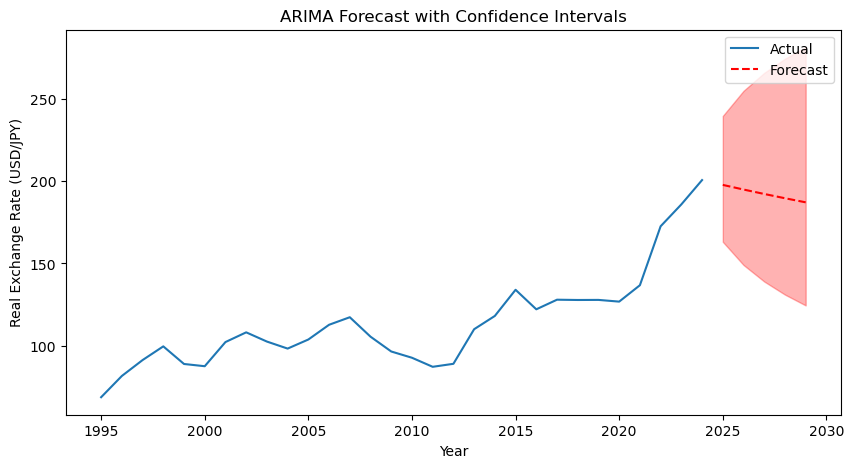

In [115]:
# Final forecasting (only valid models)
if valid_models:
    forecast_steps = 5  # Forecast for the next 5 years (or change to 4 if needed)
    for valid_model in valid_models:
        if isinstance(valid_model, VAR):
            # For VAR models, forecast for the next 5 steps (years)
            var_forecast = valid_model.forecast(var_data.values[-valid_model.k_ar:], steps=forecast_steps)
            forecast_df = pd.DataFrame(var_forecast, 
                                       index=range(df['Year'].iloc[-1] + 1, df['Year'].iloc[-1] + forecast_steps + 1), 
                                       columns=var_data.columns)
            # Plot the forecasted values
            plt.figure(figsize=(10, 5))
            plt.plot(df['Year'], np.exp(df['log_real_exchange_rate']), label="Actual Log Real Exchange Rate", color='blue')
            plt.plot(forecast_df.index, forecast_df['log_real_exchange_rate'], label="Forecasted Log Real Exchange Rate", linestyle="dashed", color='red')
            plt.legend()
            plt.title("VAR Model Forecast (Log Real Exchange Rate)")
            plt.xlabel("Year")
            plt.ylabel("Log Real Exchange Rate (USD/JPY)")
            plt.show()

        else:
            # For ARIMA models, plot forecasts with confidence intervals
            forecast = valid_model.get_forecast(steps=forecast_steps)
            forecast_values = np.exp(forecast.predicted_mean)  # Convert from log scale to original scale
            conf_int = forecast.conf_int(alpha=0.05)

            # Extract lower and upper bounds for the confidence intervals
            lower_bound = np.exp(conf_int.iloc[:, 0])  # Lower bound of the confidence interval
            upper_bound = np.exp(conf_int.iloc[:, 1])  # Upper bound of the confidence interval

            # Generate forecast index (next 5 years)
            forecast_index = range(df['Year'].iloc[-1] + 1, df['Year'].iloc[-1] + forecast_steps + 1)

            # Plot forecast with confidence intervals
            plt.figure(figsize=(10, 5))
            plt.plot(df['Year'], np.exp(df['log_real_exchange_rate']), label="Actual")  # Actual data in original scale
            plt.plot(forecast_index, forecast_values, label="Forecast", linestyle="dashed", color='red')  # Forecasted data
            plt.fill_between(forecast_index, lower_bound, upper_bound, color='red', alpha=0.3)  # Confidence intervals
            plt.legend()
            plt.title(f"{valid_model.model.__class__.__name__} Forecast with Confidence Intervals")
            plt.xlabel("Year")
            plt.ylabel("Real Exchange Rate (USD/JPY)")
            plt.show()

else:
    print("No valid models found for forecasting.")

### Check Residuals of Best Model

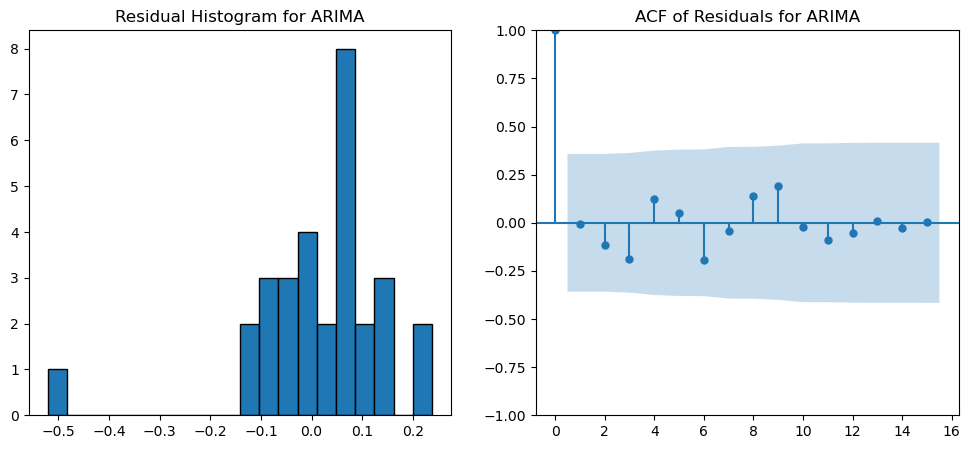

In [116]:
# Check residuals of the best model (based on AIC and Ljung-Box test)
if valid_models:
    for valid_model in valid_models:
        # Check if the model has the 'resid' attribute
        if hasattr(valid_model, 'resid'):
            residuals = valid_model.resid
            
            # For ARIMA model (univariate), plot residuals histogram and ACF
            if isinstance(residuals, pd.Series):
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                axes[0].hist(residuals, bins=20, edgecolor='k')
                axes[0].set_title(f"Residual Histogram for {valid_model.model.__class__.__name__}")
                
                sm.graphics.tsa.plot_acf(residuals, ax=axes[1])
                axes[1].set_title(f"ACF of Residuals for {valid_model.model.__class__.__name__}")
                plt.show()
            
            # For VAR model (multivariate), plot residuals histogram and ACF for each series
            elif isinstance(residuals, pd.DataFrame):
                for column in residuals.columns:
                    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                    axes[0].hist(residuals[column], bins=20, edgecolor='k')
                    axes[0].set_title(f"Residual Histogram for {valid_model.model.__class__.__name__} - {column}")
                    
                    sm.graphics.tsa.plot_acf(residuals[column], ax=axes[1])
                    axes[1].set_title(f"ACF of Residuals for {valid_model.model.__class__.__name__} - {column}")
                    plt.show()

else:
    print("No valid models to check residuals for.")